In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Training Images from Fatkun
!unzip /content/drive/MyDrive/TransferLearnImages.zip
data_root = "/content/TransferLearnImages/"

In [3]:
batch_size = 32
IMG_SIZE = (224, 224)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  seed=123,
  image_size=IMG_SIZE,
  batch_size=batch_size)

class_names = np.array(train_ds.class_names)

Found 188 files belonging to 2 classes.


In [4]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
IMG_SHAPE = IMG_SIZE + (3,)

feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=IMG_SHAPE, trainable=False)

num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [6]:
history = model.fit(train_ds, epochs=5)

Epoch 1/5
6/6 [==============================] - 0s 61ms/step - loss: 0.5015 - acc: 0.8085
Epoch 2/5
6/6 [==============================] - 0s 28ms/step - loss: 0.1180 - acc: 0.9840
Epoch 3/5
6/6 [==============================] - 0s 29ms/step - loss: 0.0415 - acc: 0.9894
Epoch 4/5
6/6 [==============================] - 0s 29ms/step - loss: 0.0203 - acc: 1.0000
Epoch 5/5
6/6 [==============================] - 0s 29ms/step - loss: 0.0122 - acc: 1.0000


['Football']


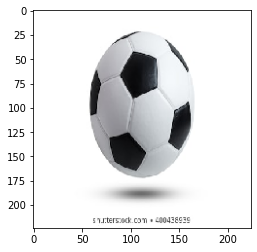

In [7]:
# test model with new image
!wget -O image.jpg https://image.shutterstock.com/image-photo/soccer-ball-isolated-on-white-260nw-400438939.jpg
#!wget -O image.jpg https://www.tennisnuts.com/images/product/full/102334-136_babolat-pure-drive_angle.jpg

# process image for model
img = tf.keras.preprocessing.image.load_img('image.jpg', target_size=IMG_SIZE)
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# display image
import matplotlib.pyplot as plt
plt.imshow(img)

# run prediction
prediction = model.predict(x)
predicted_id = np.argmax(prediction, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)